<h2><center> Welcome to the Faulty Air-Quality Sensor Challenge</h2></center>
<figure>
<center><img src ="https://drive.google.com/uc?export=view&id=1hSOAfRhJ_jo-MZAjq81VYJu5bZNL7EjD" width = "800" height = '500'/>

*About the problem*
> AirQo’s air quality sensing network has more than 120 low-cost devices deployed across Uganda; in most cases, these devices are deployed in unmonitored or perilous environments. These low-cost electronic devices are susceptible to breakdown caused by communication malfunction, aging, wear and tear, manufacturing deficiencies, incorrect calibration, mishandling and other external environmental factors. Faults lead to data inaccuracies and data loss, which impacts decisions and policies that could significantly impact people’s lives. 

*Objective of this challenge*
> In this challenge, your task is to develop a binary clasification model to identify faulty sensors, regardless of the device type. The model will be used by AirQo to automatically flag devices that have faulty readings. 

Device failure detection and monitoring is critical to AirQo’s work; faulty devices need to be identified, isolated and fixed or replaced with urgency



## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Missing values and duplicates](#Missing)
5. [Outliers](#Outliers)
6. [Feature engineering](#Engineering)
7. [Date features EDA](#Dates)
8. [Correlations - EDA](#Correlations)
9. [Preprocess test dataset](#Preprocess)
10. [Modelling](#Modelling)
11. [Making predictions of the test set and creating a submission file](#Predictions)
12. [TO DOs](#Tips)

<a name="Libraries"></a>
## 1. Importing libraries


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a name="Data"></a>
## 2. Loading data

In [3]:
# Load files
train = pd.read_csv('train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('SampleSubmission.csv')

# Preview train dataset
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0


In [3]:
# Preview test dataset
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,114.78000,22.20000,56.00000
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35000,346.73000,28.10000,63.00000
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17000,83.85000,21.60000,82.00000
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23000,53.07000,22.70000,80.00000


In [4]:
# Preview sample submission file
samplesubmission.head()

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,0


In [5]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((297177, 7), (127361, 6), (127361, 2))

<a name="Statistics"></a>
## 3. Statistical summaries

In [6]:
# Train statistical summary
train.describe(include = 'all')

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,297177,297177,293563.00000,293563.00000,293628.00000,293628.00000,297177.00000
unique,297177,293751,NaN,NaN,NaN,NaN,NaN
top,ID_QF0ZTQJ2SF5Q,2021-11-26 17:23:00,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN
first,NaN,2021-10-15 16:00:31,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-01-21 07:34:57,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.75120,38.18302,23.31655,78.65362,0.37107
std,NaN,NaN,28.52618,28.64776,3.83697,14.77272,0.48309
min,NaN,NaN,-9.45000,-9.70000,16.70000,27.00000,0.00000
25%,NaN,NaN,22.43000,19.52000,20.40000,68.00000,0.00000


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from *2021-10-15 16:00:34* to *2022-01-21 07:34:57*
 - There is a high correlation between Sensor1_PM2.5	and Sensor2_PM2.5
 - Minimum recorded temperature is *16.70000* and a maximum *34.90000*

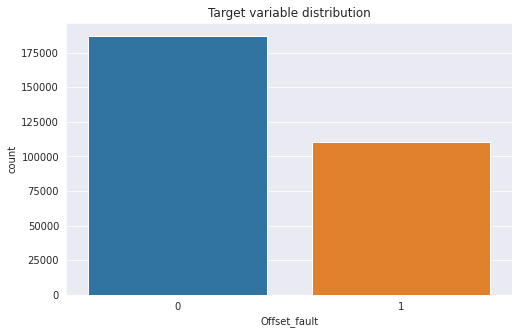

In [7]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["Offset_fault"])
plt.title('Target variable distribution')
plt.show()

The target variable is not well balanced.
Some of the techniques to handle imbalanceness include:
- Smote
- Oversampling
- Undersampling ...

<a name="Missing"></a>
## 4. Missing values and duplicates

In [8]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

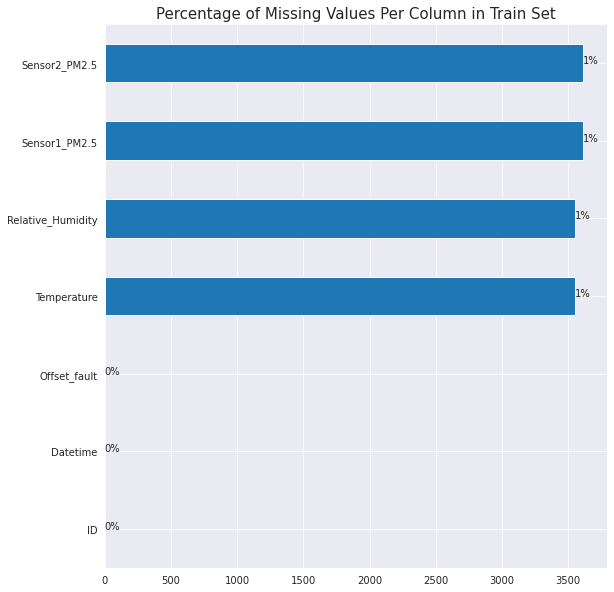

In [12]:
# Plot missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [10]:
# Fill missing values with zeros
# train = train.fillna(0)

In [13]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

No duplictes 

<a name="Outliers"></a>
## 5. Outliers

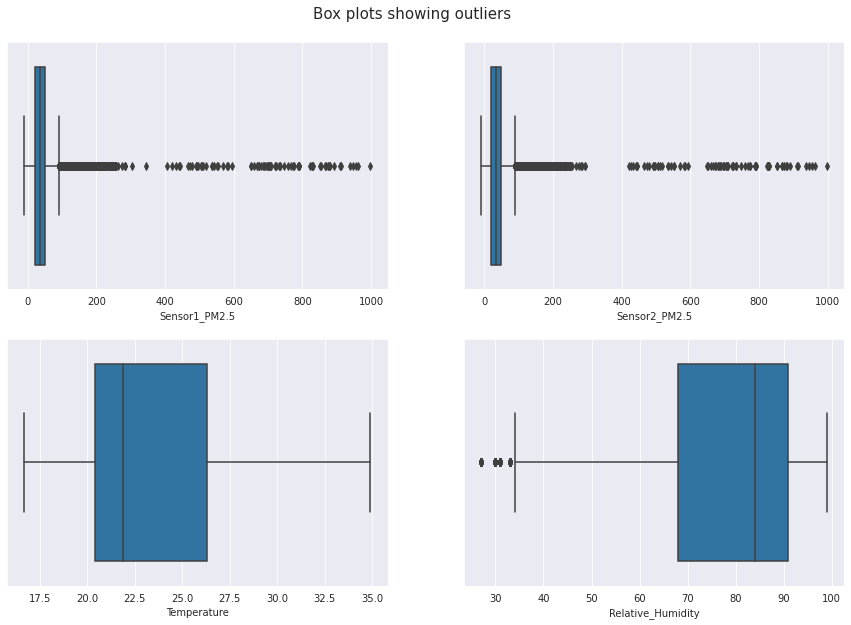

In [4]:
# Plotting boxplots for each of the numerical columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']):
  sns.boxplot(train[name], ax = ax)

Outliers are those data points which differs significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...


<a name="Engineering"></a>
## 6. Feature engineering

In [5]:
# Extract day, month year and hour from the Datetime column
# day
train['Datetime_day'] = train.Datetime.dt.day

# month
train['Datetime_month'] = train.Datetime.dt.month
 
# year
train['Datetime_year'] = train.Datetime.dt.year

# hour
train['Datetime_hour'] = train.Datetime.dt.hour

# week
train['Datetime_week'] = train.Datetime.dt.week

# Preview engineered date features
train[['Datetime', 'Datetime_day', 'Datetime_month', 'Datetime_year', 'Datetime_hour']].head()

,Datetime,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,2021-11-03 04:06:31,3,11,2021,4
1,2021-11-08 18:43:23,8,11,2021,18
2,2021-11-07 09:50:33,7,11,2021,9
3,2022-01-01 18:55:15,1,1,2022,18
4,2021-11-05 22:23:48,5,11,2021,22


<a name="Dates"></a>
## 7. Date features EDA

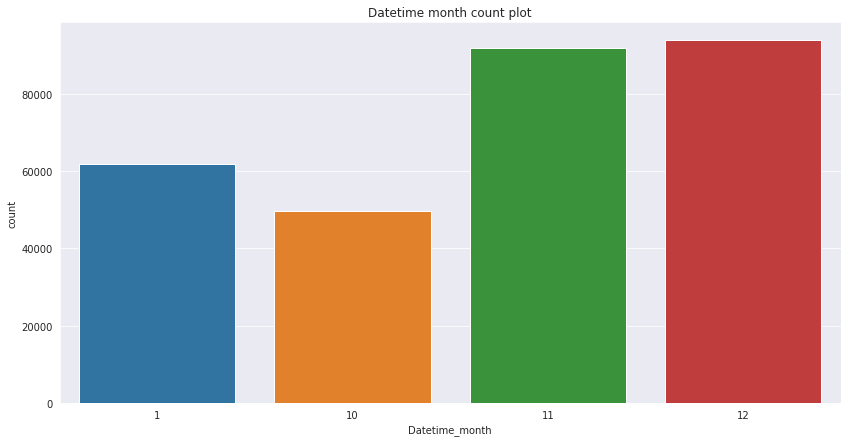

In [16]:
# Datetime month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'Datetime_month', data = train)
plt.title('Datetime month count plot')
plt.show()

- The only months available in the train set include *Jan, Oct, Nov and Dec*
- March has the least number of observations in the dataset while December has the highest number of observations

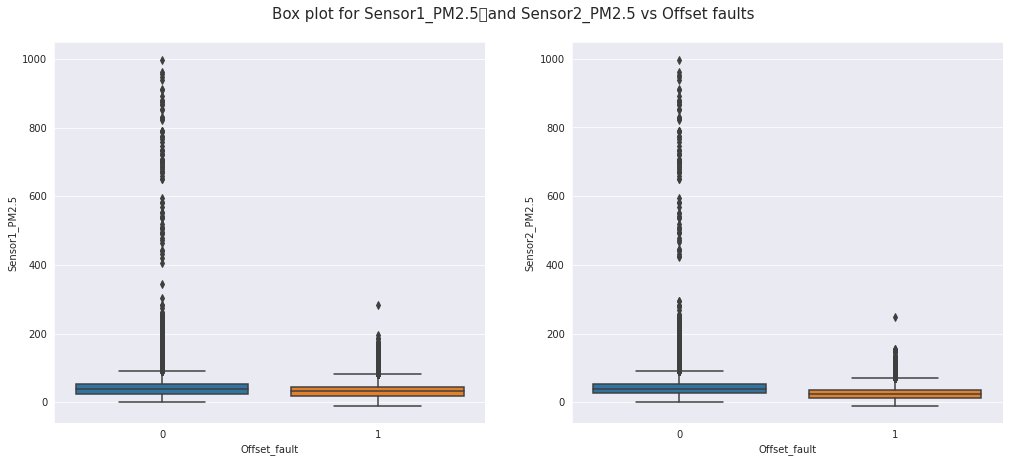

In [17]:
# Box plots for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
fig.suptitle('Box plot for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults', y= 0.95, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5', 'Sensor2_PM2.5']):
  sns.boxplot(train.Offset_fault, train[name], ax= ax)

 - Sensor 1 and sensor 2 are highly correlated with majority of the non faulty observations having the highest number of outliers

<a name="Correlations"></a>
## 8. Correlations - EDA

<Figure size 1440x864 with 0 Axes>

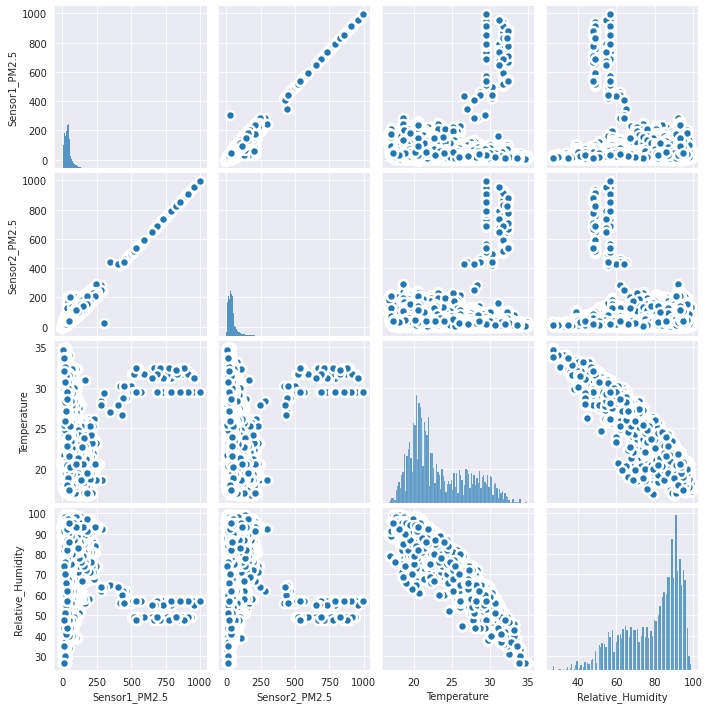

In [18]:
# Type of correlations 
plt.figure(figsize = (20, 12))
num_cols = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']
sns.pairplot(train[num_cols], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

 - There is a positive correlation between Sensor1_PM2.5	Sensor2_PM2.5
 - There is a negative correlation between temperature and humidity
 - There seems to be no correlation between sensor PM2.5 and temperature/humidity

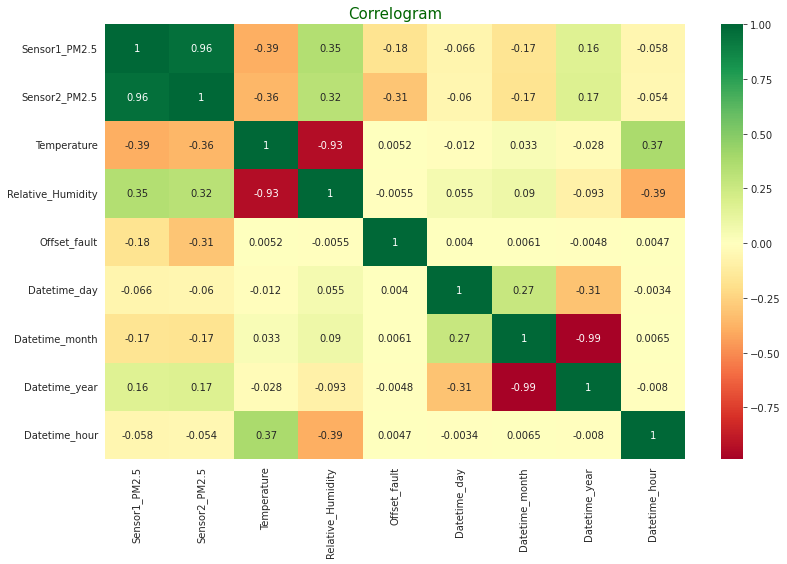

In [19]:
# Quantify correlations
corr = train.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

- There is a 0.96 positive correlation between sensor1 PM2.5 and sensor2 PM2.5
- There is a -0.99 negative correlation between temperature and humidity

<a name="Preprocess"></a>
## 9.  Preprocess test dataset

In [6]:
# Extract day, month and year from the Datetime column
test['Datetime_day'] = test.Datetime.dt.day
test['Datetime_month'] = test.Datetime.dt.month
test['Datetime_year'] = test.Datetime.dt.year
test['Datetime_hour'] = test.Datetime.dt.hour
test['Datetime_week'] = test.Datetime.dt.week

# Fill in missing values with Zeroes
# test = test.fillna(0)

# Preview engineered test set
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_week
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,114.78000,22.20000,56.00000,28,1,2022,8,4
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,NaN,NaN,16,2,2022,21,7
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35000,346.73000,28.10000,63.00000,24,1,2022,17,4
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17000,83.85000,21.60000,82.00000,31,1,2022,7,5
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23000,53.07000,22.70000,80.00000,31,1,2022,0,5


In [10]:
# combine train and test
data = pd.concat([train.assign(is_train=1), test.assign(is_train=0)], sort = False)
data

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_week,is_train
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0.00000,3,11,2021,4,44,1
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0.00000,8,11,2021,18,45,1
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0.00000,7,11,2021,9,44,1
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0.00000,1,1,2022,18,52,1
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0.00000,5,11,2021,22,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127356,ID_HNCS9Q2GNCQB,2022-02-13 00:37:14,33.65000,42.23000,NaN,NaN,NaN,13,2,2022,0,6,0
127357,ID_GIIQYTE11L3H,2022-03-09 16:26:42,21.23000,15.72000,NaN,NaN,NaN,9,3,2022,16,10,0
127358,ID_EC7F1P4GXKCL,2022-02-18 14:47:28,41.45000,47.25000,NaN,NaN,NaN,18,2,2022,14,7,0
127359,ID_J64RVG2BRAG0,2022-03-11 19:14:11,28.60000,27.27000,NaN,NaN,NaN,11,3,2022,19,10,0


In [21]:
data.isna().sum()

ID                        0
Datetime                  0
Sensor1_PM2.5          3614
Sensor2_PM2.5          3614
Temperature           91639
Relative_Humidity     91639
Offset_fault         127361
Datetime_day              0
Datetime_month            0
Datetime_year             0
Datetime_hour             0
Datetime_week             0
is_train                  0
dtype: int64

In [22]:
# fill the mean tempreture and relative humidity of by grouping them by week 
data["Temperature"] =  data.groupby('Datetime_week')['Temperature'].transform('mean')
data["Relative_Humidity"] =  data.groupby('Datetime_week')['Relative_Humidity'].transform('mean')

data.isna().sum()


ID                        0
Datetime                  0
Sensor1_PM2.5          3614
Sensor2_PM2.5          3614
Temperature           76893
Relative_Humidity     76893
Offset_fault         127361
Datetime_day              0
Datetime_month            0
Datetime_year             0
Datetime_hour             0
Datetime_week             0
is_train                  0
dtype: int64

In [27]:
data.describe(include = 'all')

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_week,is_train
count,424538,424538,420924.00000,420924.00000,347645.00000,347645.00000,297177.00000,424538.00000,424538.00000,424538.00000,424538.00000,424538.00000,424538.00000
unique,424538,419843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_QF0ZTQJ2SF5Q,2022-01-18 03:37:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2021-10-15 16:00:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-03-14 14:50:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,41.36971,39.93051,23.32195,77.43140,0.37107,15.65939,6.98422,2021.44551,11.41703,29.04089,0.70000
std,NaN,NaN,28.33547,28.65414,0.85758,5.33788,0.48309,8.93365,4.75115,0.49702,6.93190,20.70265,0.45826
min,NaN,NaN,-9.45000,-9.70000,21.39444,62.39516,0.00000,1.00000,1.00000,2021.00000,0.00000,1.00000,0.00000
25%,NaN,NaN,23.07000,21.03000,22.68374,74.35658,0.00000,8.00000,2.00000,2021.00000,5.00000,7.00000,0.00000


In [29]:
mothly_mean_temp = [24, 24.5, 23.5, 23, 22.5, 22, 21, 21.5, 21.5, 22.5, 22.5, 23]
monthly_mean_hum = [72, 72, 76, 83, 84, 79, 75, 77, 81, 83, 85, 80]
print(len(mothly_mean_temp), len(monthly_mean_hum))

12 12


In [37]:
# fill the null values with the monthly mean tempreture and relative humidity
for month in range(12):
    t_inx = data[(data.Datetime_month == month + 1) & (data.Temperature.isna())].index
    h_inx = data[(data.Datetime_month == month + 1) & (data.Relative_Humidity.isna())].index

    data.Temperature.loc[t_inx] = mothly_mean_temp[month]
    data.Relative_Humidity.loc[h_inx] = monthly_mean_hum[month]

data.isna().sum()

ID                        0
Datetime                  0
Sensor1_PM2.5          3614
Sensor2_PM2.5          3614
Temperature               0
Relative_Humidity         0
Offset_fault         127361
Datetime_day              0
Datetime_month            0
Datetime_year             0
Datetime_hour             0
Datetime_week             0
is_train                  0
dtype: int64

In [38]:
for sen in ['Sensor1_PM2.5', 'Sensor2_PM2.5']:
    data[sen] = data[sen].fillna(data[sen].mean())
data.isna().sum()

ID                        0
Datetime                  0
Sensor1_PM2.5             0
Sensor2_PM2.5             0
Temperature               0
Relative_Humidity         0
Offset_fault         127361
Datetime_day              0
Datetime_month            0
Datetime_year             0
Datetime_hour             0
Datetime_week             0
is_train                  0
dtype: int64

<a name="Modelling"></a>
## 10.  Modelling

In [39]:
train, test = data[data.is_train == 1], data[data.is_train == 0]
train

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_week,is_train
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,21.89436,85.17815,0.00000,3,11,2021,4,44,1
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,24.50000,72.00000,0.00000,8,11,2021,18,45,1
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,21.89436,85.17815,0.00000,7,11,2021,9,44,1
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,22.56224,83.26459,0.00000,1,1,2022,18,52,1
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,21.89436,85.17815,0.00000,5,11,2021,22,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297172,ID_AQFTZIKVX2QL,2021-11-19 12:32:00,36.40000,37.77000,23.55552,77.09837,0.00000,19,11,2021,12,46,1
297173,ID_2X0AJPWOMJNA,2021-11-22 01:22:54,50.12000,40.63000,22.75265,80.39240,1.00000,22,11,2021,1,47,1
297174,ID_0OAQMV7USTI4,2021-11-05 01:27:31,53.68000,45.23000,21.89436,85.17815,1.00000,5,11,2021,1,44,1
297175,ID_Y8FDAO06VXGJ,2021-11-23 22:09:30,96.45000,114.67000,22.75265,80.39240,0.00000,23,11,2021,22,47,1


In [40]:
# Selecting the independent variables and the target variable
train_feats = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity',	'Datetime_day',\
               'Datetime_month',	'Datetime_year', 'Datetime_hour', 'Datetime_week']

X = train[train_feats].fillna(0)
y = train.Offset_fault

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
clf = RandomForestClassifier(max_depth = 3, random_state = 0)
# clf = CatBoostClassifier(verbose=False)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.724959059604729


              precision    recall  f1-score   support

         0.0       0.71      0.96      0.81     55966
         1.0       0.83      0.33      0.47     33188

    accuracy                           0.72     89154
   macro avg       0.77      0.64      0.64     89154
weighted avg       0.75      0.72      0.69     89154



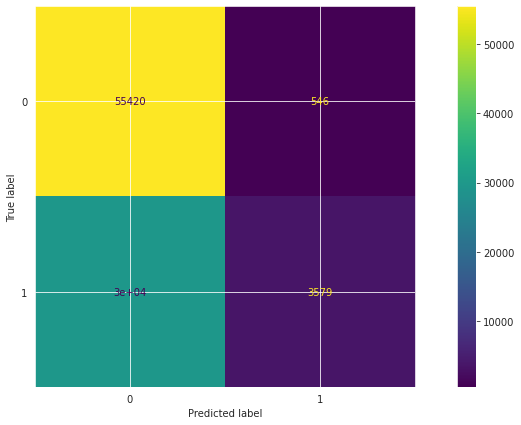

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

In [42]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

new_train = pd.DataFrame(x_smote, columns = train_feats)
new_train['Offset_fault'] = y_smote.astype(int)
new_train

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_week,Offset_fault
0,52.58000,49.52000,21.89436,85.17815,3,11,2021,4,44,0
1,35.25000,33.40000,24.50000,72.00000,8,11,2021,18,45,0
2,19.18000,23.50000,21.89436,85.17815,7,11,2021,9,44,0
3,19.40000,15.48000,22.56224,83.26459,1,1,2022,18,52,0
4,38.30000,34.77000,21.89436,85.17815,5,11,2021,22,44,0
...,...,...,...,...,...,...,...,...,...,...
373801,24.00033,19.29512,24.50000,72.00000,3,1,2022,4,1,1
373802,27.10802,25.23019,24.50000,72.00000,17,1,2022,10,3,1
373803,16.47334,10.50189,23.73420,76.80364,26,10,2021,13,43,1
373804,34.49113,29.51038,24.50000,72.00000,14,1,2022,11,2,1


In [43]:
import numpy as np
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingClassifier


class ModelEvalPredCla:
    def __init__(self, train_df, test_df, in_cols, target):
        self.train_df = train_df
        self.test_df = test_df
        self.in_cols = in_cols 
        self.target = target
    
    def eval_model(self, models, show=True, shuf=False):
        kf = KFold(n_splits=5, shuffle=shuf)
        scores = []
        for train, test in kf.split(self.train_df):
            results = []
            vot_cls = VotingClassifier(estimators=models, voting='soft')
            vot_cls.fit(self.train_df[self.in_cols].iloc[train], self.train_df[self.target].iloc[train])
            acc = accuracy_score(self.train_df[self.target].iloc[test], vot_cls.predict(self.train_df[self.in_cols].iloc[test]))
            scores.append(acc)
            if show:
                print(acc)
        if show:
            print("Average score in 5-fold CV:", np.mean(scores))
        return np.mean(scores)
        
    def predict(self, models):
        vot_cls = VotingClassifier(estimators=models, voting='soft')
        vot_cls.fit(self.train_df[self.in_cols], self.train_df[self.target])
        return vot_cls.predict(self.test_df[self.in_cols])

In [44]:
modcla = ModelEvalPredCla(new_train, test, train_feats, "Offset_fault")

In [45]:
# import classifier models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = [
    # ('Logistic Regression', LogisticRegression()),
    # ('Random Forest', RandomForestClassifier()),
    # ('SVM', SVC()),
    # ('KNN', KNeighborsClassifier()),
    # ('Naive Bayes', GaussianNB()),
    # ('Decision Tree', DecisionTreeClassifier()),
    # ('CatBoost', CatBoostClassifier(verbose=0)),
    # ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier())
]

modcla.eval_model(models, show=True, shuf=False)

0.938993071346406
0.9407980096574418
0.94020946750311
0.9412929201054026
0.9423094929174302
Average score in 5-fold CV: 0.9407205923059581


0.9407205923059581

<a name="Predictions"></a>
## 11. Making predictions of the test set and creating a submission file

In [46]:
preds = []
for mod in models:
    print(mod[0])
    mod[1].fit(X, y)
    preds.append(mod[1].predict_proba(test[train_feats]))
preds

LightGBM


[array([[0.99579196, 0.00420804],
        [0.9902716 , 0.0097284 ],
        [0.99339267, 0.00660733],
        ...,
        [0.99593846, 0.00406154],
        [0.60695682, 0.39304318],
        [0.84661598, 0.15338402]])]

In [48]:
pm = np.mean([i[:, 1] for i in preds], axis=0)
pm

array([0.00420804, 0.0097284 , 0.00660733, ..., 0.00406154, 0.39304318,
       0.15338402])

In [49]:
# round the values to 1 and 0 with threshold 0.5
threshold = 0.5
pm_round = np.where(pm > threshold, 1, 0)
pm_round.sum()

32073

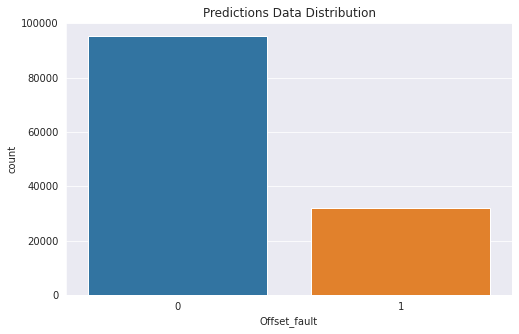

In [50]:
# Make prediction on the test set
test_df = test[train_feats]
predictions = pm_round #modcla.predict(models)#clf.predict(test_df)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.Offset_fault = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Offset_fault)
plt.title('Predictions Data Distribution');

 - Majority of the model predictions are 0

In [51]:
# Create file
sub_file.to_csv('lt-oversample-null.csv', index = False)

<a name="Tips"></a>
##12. TO DOs

1. Generate more features, you can work on aggregating the columns( e.g mean temperature , mean humidity  etc)
2. For the datetime you can generate more features, day of the week, week of the year ...
3. Perform more EDA to get a better Understanding of the data, 
4. Try other classifier models
5. Experiment with different startegies of handling the missing values




## ALL THE BEST! 